In [1]:
import theano.sandbox.cuda
theano.sandbox.cuda.use("gpu0")

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: GeForce GTX 780


In [2]:
%ls -rlth

total 7.4G
-rw-r--r-- 1 dueo dueo 2.3G Jul 28 20:17 HCS_48x48.npz
-rw-r--r-- 1 dueo dueo 965K Jul 29 11:16 DataHandling.ipynb
-rw-r--r-- 1 dueo dueo  229 Jul 29 11:55 README.md
-rw-r--r-- 1 dueo dueo 2.6M Jul 29 20:43 net_aug_epoch42_91prec.pickle
-rw-r--r-- 1 dueo dueo 2.6M Jul 29 21:13 net_aug_epoch69_92prec.pickle
-rw-r--r-- 1 dueo dueo 5.2G Jul 29 21:17 HCS_72x72.npz
-rw-r--r-- 1 dueo dueo 930K Jul 29 21:22 FirstNetwork.ipynb
-rw-r--r-- 1 dueo dueo 934K Jul 29 21:22 FirstNetwork_dummy.ipynb


In [3]:
import skimage
skimage.__version__ # We need at least version 0.11.3

'0.11.3'

In [4]:
import gzip
import numpy as np
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import time
%matplotlib inline

In [5]:
start = time.time()
#with open('HCS_48x48.npz') as f:
npzfile = np.load('HCS_72x72.npz')
print ("Loaded data in " + str(time.time() - start))

Loaded data in 0.000811815261841


In [6]:
npzfile.files

['arr_1', 'arr_0', 'arr_2']

In [7]:
start = time.time()
cell_rows = npzfile['arr_0']
X = npzfile['arr_1']
Y = npzfile['arr_2']
print ("Loaded data in " + str(time.time() - start))

Loaded data in 10.5933959484


In [8]:
np.shape(cell_rows), np.shape(Y), np.shape(X), type(X)

((52950,), (52950,), (52950, 5, 72, 72), numpy.ndarray)

(-0.5, 3.5)

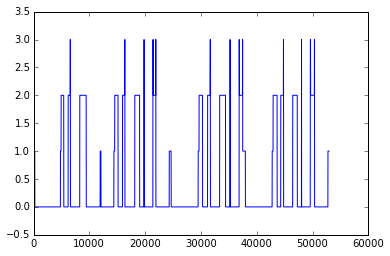

In [9]:
plt.plot(Y)
plt.ylim(-0.5,3.5)

### Normalization

In [10]:
Xmean = X.mean(axis = 0)
XStd = np.sqrt(X.var(axis=0))
X = (X-Xmean)/(XStd + 0.01)

In [11]:
np.min(X), np.max(X), np.mean(X)

(-2.5272908, 58.301613, -3.3162789e-07)

In [12]:
Y = np.asarray(Y,dtype='int32')

### Some examples (after normalization)
rows are the different compounds

Populating the interactive namespace from numpy and matplotlib
Average values -0.221023604274, -0.841403484344, -0.988224565983, -0.245223581791


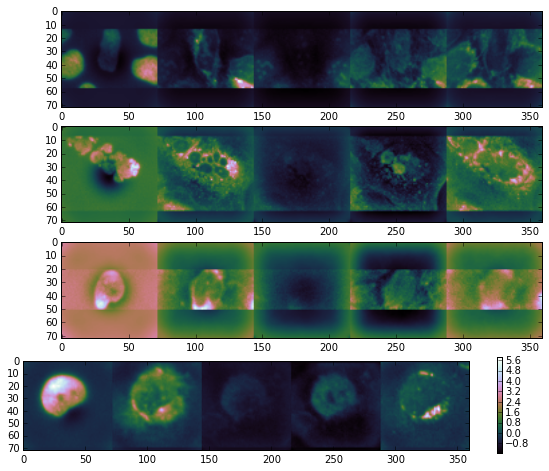

In [13]:
%pylab inline
cmap = plt.get_cmap('cubehelix')
pylab.rcParams['figure.figsize'] = (10.0, 10.0)
idx = (np.argwhere(Y == 0)[0][0], 
       np.argwhere(Y == 1)[0][0], 
       np.argwhere(Y == 2)[0][0], 
       np.argwhere(Y == 3)[0][0])
cmap = plt.get_cmap('cubehelix')
plt.subplot(511) 
plt.imshow(np.concatenate(X[idx[0],:,:,:],axis=1), cmap=plt.get_cmap('cubehelix'))
plt.subplot(512) 
plt.imshow(np.concatenate(X[idx[1],:,:,:],axis=1), cmap=plt.get_cmap('cubehelix'))
plt.subplot(513) 
plt.imshow(np.concatenate(X[idx[2],:,:,:],axis=1), cmap=plt.get_cmap('cubehelix'))
plt.subplot(514) 
plt.imshow(np.concatenate(X[idx[3],:,:,:],axis=1), cmap=plt.get_cmap('cubehelix'))
print('Average values {0}, {1}, {2}, {3}'.format(np.mean(X[idx[0],:,:,:]),np.mean(X[idx[1],:,:,:]),np.mean(X[idx[2],:,:,:]),np.mean(X[idx[3],:,:,:])))
plt.colorbar()
plt.show()

### Splitting in training and test-set

#### Version 1
We take all, which is  below 40000 for training and validation and images above for testing.

In [200]:
# Currently a Acc. of 0.8250
split = 40000
X_train = X[0:split,:,:,:]
Y_train = Y[0:split]
X_test = X[split:,:,:,:]
Y_test = Y[split:]

#### Version 2
80%, 20% randomly choosen

In [14]:
# Currently a Acc. of 0.8976
perm1 = np.random.permutation(len(Y))
N_split = int(len(Y) * 0.8)
N_split
idx_train  = perm1[:N_split]
idx_test  = perm1[N_split:]
    

X_train = X[idx_train,:,:,:]
Y_train = Y[idx_train]
X_test = X[idx_test,:,:,:]
Y_test = Y[idx_test]

#### Permuting the training set

In [15]:
perm = np.random.permutation(len(Y_train))
XX = X_train[perm,:,:,:]
YY = Y_train[perm]

In [18]:
PIXELS = 72

from lasagne import layers
from lasagne import nonlinearities
from nolearn.lasagne import NeuralNet

net1 = NeuralNet(
    # Geometry of the network
    layers=[
        ('input', layers.InputLayer),
        
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),
        
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),
        
        ('hidden3', layers.DenseLayer),
        ('dropout3', layers.DropoutLayer),
        
        ('hidden4', layers.DenseLayer),
        ('dropout4', layers.DropoutLayer),
        
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 5, PIXELS, PIXELS), #None in the first axis indicates that the batch size can be set later
    conv1_num_filters=32, conv1_filter_size=(5, 5), pool1_pool_size=(2, 2), #pool_size used to be called ds in old versions of lasagne
    dropout1_p=0.0,
    
    conv2_num_filters=64, conv2_filter_size=(3, 3), pool2_pool_size=(2, 2),
    dropout2_p=0.3,
    
    hidden3_num_units=100,
    dropout3_p=0.3,
    
    hidden4_num_units=20,
    dropout4_p=0.3,
    
    output_num_units=5, output_nonlinearity=nonlinearities.softmax,

    # learning rate parameters
    update_learning_rate=0.01,
    update_momentum=0.9,
    regression=False,
    # We only train for 10 epochs
    max_epochs=20,
    verbose=1,

    # Training test-set split
    eval_size = 0.2
    )

In [17]:
net = net1.fit(XX,YY)

/usr/local/lib/python2.7/dist-packages/Lasagne-0.1dev-py2.7.egg/lasagne/init.py:86: UserWarning: The uniform initializer no longer uses Glorot et al.'s approach to determine the bounds, but defaults to the range (-0.01, 0.01) instead. Please use the new GlorotUniform initializer to get the old behavior. GlorotUniform is now the default for all layers.
  warnings.warn("The uniform initializer no longer uses Glorot et al.'s "
/usr/local/lib/python2.7/dist-packages/Lasagne-0.1dev-py2.7.egg/lasagne/layers/helper.py:69: UserWarning: get_all_layers() has been changed to return layers in topological order. The former implementation is still available as get_all_layers_old(), but will be removed before the first release of Lasagne. To ignore this warning, use `warnings.filterwarnings('ignore', '.*topo.*')`.
  warnings.warn("get_all_layers() has been changed to return layers in "


# Neural Network with 1663153 learnable parameters

## Layer information

|   # | name     | size     |
|----:|:---------|:---------|
|   0 | input    | 5x72x72  |
|   1 | conv1    | 32x68x68 |
|   2 | pool1    | 32x34x34 |
|   3 | dropout1 | 32x34x34 |
|   4 | conv2    | 64x32x32 |
|   5 | pool2    | 64x16x16 |
|   6 | dropout2 | 64x16x16 |
|   7 | hidden3  | 100      |
|   8 | dropout3 | 100      |
|   9 | hidden4  | 20       |
|  10 | dropout4 | 20       |
|  11 | output   | 5        |

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  ------
      1       0.56267       0.42618      1.32027      0.83921  24.64s
      2       0.43495       0.36361      1.19619      0.86348  24.62s
      3       0.39214       0.35688      1.09878      0.86569  24.58s
      4       0.36160       0.33054      1.09397      0.87760  24.63s
      5       0.34011       0.33240      1.02318      0.87491  24.63s
      6       0.32

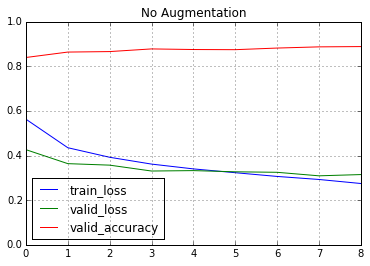

In [35]:
%matplotlib inline
import pandas as pd
dfNoAug = pd.DataFrame(net.train_history_)
dfNoAug[['train_loss','valid_loss','valid_accuracy']].plot(title='No Augmentation', ylim=(0,1))

We see a overfitting after approx 20 Epochs.

In [217]:
pred = net.predict(X_test)

In [218]:
sum(pred == Y_test)/float(len(Y_test))

0.89763928234183188

### Calucation of the confusion matrix

In [219]:
from sklearn.metrics import confusion_matrix
import pandas as pd
names = ('DMSO True', 'PACLITAXEL True', 'METOCLOPRAMIDE True', 'DIGOXIN True')
m = confusion_matrix(pred, Y_test)
df = pd.DataFrame(m)
df.columns = names
names = ('DMSO Pred', 'PACLITAXEL Pred', 'METOCLOPRAMIDE Pred', 'DIGOXIN Pred')
df.index = names
df

,DMSO True,PACLITAXEL True,METOCLOPRAMIDE True,DIGOXIN True
DMSO Pred,7877,67,625,0
PACLITAXEL Pred,63,300,60,2
METOCLOPRAMIDE Pred,226,37,1248,0
DIGOXIN Pred,0,3,1,81


In [220]:
np.sum(Y_test==0)

8166

# Using data augmentation
Rotations are a bit tricky in skimage ...

-10.0 15.5 -9.98975055173 15.4856895176 


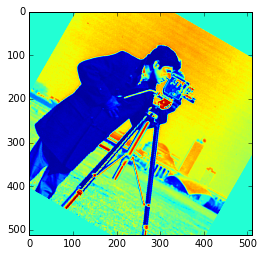

In [62]:
from skimage import data
from skimage import transform as tf
image = np.asarray(data.camera())/10.0 - 10.0

# See http://stackoverflow.com/questions/25895587/python-skimage-transform-affinetransform-rotation-center
tf_rotate = tf.SimilarityTransform(rotation=np.deg2rad(30))
shift_y, shift_x = np.array(image.shape[:2]) / 2.
tf_shift = tf.SimilarityTransform(translation=[-shift_x, -shift_y])
tf_shift_inv = tf.SimilarityTransform(translation=[shift_x, shift_y])
tform = (tf_shift + (tf_rotate + tf_shift_inv)).inverse 


#tform = tf.SimilarityTransform(scale=1.01, rotation=np.pi/8, translation=(10, 2))
dd = tf.warp(image, tform, preserve_range = True)
plt.imshow(dd)
print('{0} {1} {2} {3} '.format(np.min(image), np.max(image), np.min(dd), np.max(dd)))


In [70]:
tf_shift_inv + tf_shift_inv.inverse + tf.SimilarityTransform(scale=np.random.uniform(0.9,1.10))

before -0.707928299904 after -0.64834356308
before -0.586495280266 after -0.539910674095
before -0.557862579823 after -0.529366970062
before -0.372540026903 after -0.346690237522
before -0.278084158897 after -0.304905086756
before 0.335318505764 after 0.386925011873
before -0.408142834902 after -0.382096081972
before 0.389631301165 after 0.401790708303
before 0.324352145195 after 0.324352145195
before -0.494309455156 after -0.442157119513
before -0.280846685171 after -0.271732151508
before -0.0134089319035 after 0.00298927444965
before 1.06093037128 after 1.0342912674
before 0.0782237499952 after 0.0917863026261
before -0.439510494471 after -0.415822923183
before 0.970640420914 after 0.952752172947
before -0.140510842204 after -0.114466503263
before 0.319754719734 after 0.313270628452


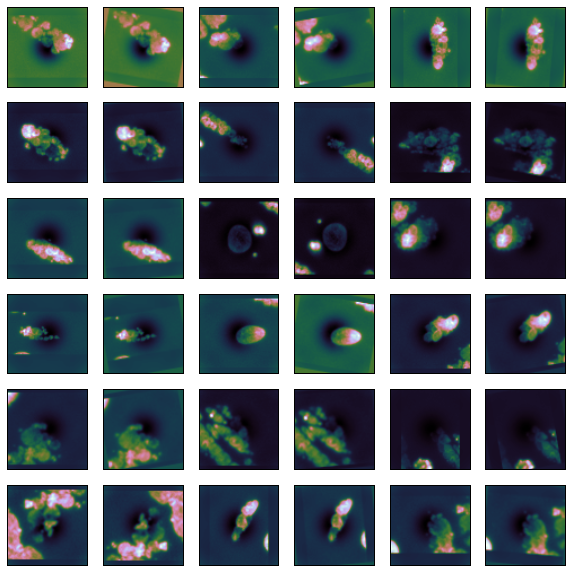

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import numpy as np
from skimage import transform as tf

rots = np.deg2rad(np.asarray((90,180,0,5,-5,10,-10)))
dists = (-5,5)

def manipulateTrainingData(Xb):
    retX = np.zeros((Xb.shape[0], Xb.shape[1], Xb.shape[2], Xb.shape[3]), dtype='float32')
    for i in range(len(Xb)):
        rot = rots[np.random.randint(0, len(rots))]
        
        tf_rotate = tf.SimilarityTransform(rotation=rot)
        shift_y, shift_x = np.array((X.shape[2], X.shape[3])) / 2.
        tf_shift = tf.SimilarityTransform(translation=[-shift_x, -shift_y])
        tf_shift_inv = tf.SimilarityTransform(translation=[shift_x, shift_y])
        tform_rot = (tf_shift + (tf_rotate + tf_shift_inv)).inverse 
        
        ## TODO add the transformations
        #dist = dists[np.random.randint(0, len(dists))]
        scale = np.random.uniform(0.9,1.10)
        d = tf.SimilarityTransform(scale=scale)
        tform_other = tform_rot 
        
        for c in range(np.shape(X)[1]):
            maxAbs = 256.0;np.max(np.abs(Xb[i,c,:,:]))
            # Needs at lease 0.11.3
            retX[i,c,:,:] = tf.warp(Xb[i,c,:,:], tform_other, preserve_range = True) # "Float Images" are only allowed to have values between -1 and 1        
    return retX


Xb = np.copy(X[0:100,:,:,:])
Xb = manipulateTrainingData(Xb)

fig = plt.figure(figsize=(10,10))
for i in range(18):
    a=fig.add_subplot(6,6,2*i+1,xticks=[], yticks=[])
    plt.imshow(X[i,0,:,:], cmap=plt.get_cmap('cubehelix'))
    a=fig.add_subplot(6,6,2*i+2,xticks=[], yticks=[])
    plt.imshow(Xb[i,0,:,:], cmap=plt.get_cmap('cubehelix'))
    print('before {0} after {1}'.format(np.mean(X[i,1,:,:]), np.mean(Xb[i,1,:,:])))

In [ ]:
from nolearn.lasagne import BatchIterator

class SimpleBatchIterator(BatchIterator):

    def transform(self, Xb, yb):
        Xb, yb = super(SimpleBatchIterator, self).transform(Xb, yb)
        #return Xb[:,:,:,::-1], yb #<--- Here we do the flipping of the images
        return manipulateTrainingData(Xb), yb
    
# Setting the new batch iterator
net1Aug = net1
net1Aug.max_epochs = 800
net1Aug.batch_iterator_train = SimpleBatchIterator(256)
netAug = net1Aug.fit(XX, YY)

# Neural Network with 1663153 learnable parameters

## Layer information

|   # | name     | size     |
|----:|:---------|:---------|
|   0 | input    | 5x72x72  |
|   1 | conv1    | 32x68x68 |
|   2 | pool1    | 32x34x34 |
|   3 | dropout1 | 32x34x34 |
|   4 | conv2    | 64x32x32 |
|   5 | pool2    | 64x16x16 |
|   6 | dropout2 | 64x16x16 |
|   7 | hidden3  | 100      |
|   8 | dropout3 | 100      |
|   9 | hidden4  | 20       |
|  10 | dropout4 | 20       |
|  11 | output   | 5        |

    158       0.07170       0.35593      0.20146      0.91933  79.84s
    159       0.07194       0.36343      0.19795      0.92097  79.97s
    160       0.07016       0.37068      0.18928      0.92213  79.92s

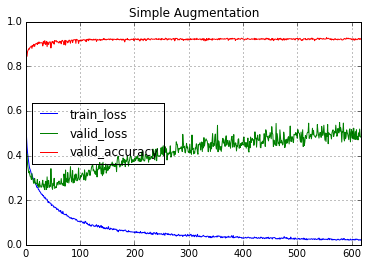

In [44]:
%matplotlib inline
import pandas as pd
dfAug = pd.DataFrame(net1Aug.train_history_)
dfAug[['train_loss','valid_loss','valid_accuracy']].plot(title='Simple Augmentation', ylim=(0,1))

In [37]:
dfAug

,dur,epoch,train_loss,train_loss_best,valid_accuracy,valid_loss,valid_loss_best
0,79.869824,1,0.613137,True,0.813558,0.462344,True
1,79.705321,2,0.484879,True,0.845060,0.406047,True
2,80.048048,3,0.439446,True,0.844477,0.406712,False
3,79.239134,4,0.410501,True,0.866631,0.359242,True
4,78.818700,5,0.389899,True,0.871879,0.342084,True
5,79.127945,6,0.371006,True,0.878408,0.322667,True
6,79.092974,7,0.353026,True,0.875718,0.330082,False
7,79.142901,8,0.340958,True,0.882382,0.315252,True
8,78.943085,9,0.335281,True,0.885746,0.305561,True
9,79.029188,10,0.325846,True,0.887046,0.303322,True


In [45]:
pred = net1Aug.predict(X_test)

In [46]:
sum(pred == Y_test)/float(len(Y_test))

0.92540132200188863

In [47]:
from sklearn.metrics import confusion_matrix
import pandas as pd
names = ('DMSO True', 'PACLITAXEL True', 'METOCLOPRAMIDE True', 'DIGOXIN True')
m = confusion_matrix(pred, Y_test)
df = pd.DataFrame(m)
df.columns = names
names = ('DMSO Pred', 'PACLITAXEL Pred', 'METOCLOPRAMIDE Pred', 'DIGOXIN Pred')
df.index = names
df

,DMSO True,PACLITAXEL True,METOCLOPRAMIDE True,DIGOXIN True
DMSO Pred,7895,58,495,0
PACLITAXEL Pred,6,312,10,1
METOCLOPRAMIDE Pred,184,35,1502,0
DIGOXIN Pred,0,1,0,91


In [48]:
cm_normalized = m.astype('float') / m.sum(axis=0)[:, np.newaxis]
print('Normalized confusion matrix')
pd.DataFrame(cm_normalized)

Normalized confusion matrix


,0,1,2,3
0,0.976500,0.007174,0.061224,0.000000
1,0.014778,0.768473,0.024631,0.002463
2,0.091679,0.017439,0.748381,0.000000
3,0.000000,0.010870,0.000000,0.989130


In [49]:
np.mean(cm_normalized[diag_indices(4)])

0.87062092490878329